In [23]:
from matplotlib import pyplot as plt
from datetime import datetime
import math
from pprint import pprint

sys.path.append('../..')
from model.processing import query_sqlPad
time_range = ('2024-7-15T00:00:00.000Z', '2024-7-16T00:00:00.000Z')

In [12]:
query = f"""
WITH normalized_trades AS (
  SELECT
    timestamp,
    block,
    who,
    operation,
    (SELECT symbol FROM token_metadata WHERE id = asset_in LIMIT 1) AS asset_in,
    (SELECT symbol FROM token_metadata WHERE id = asset_out LIMIT 1) AS asset_out,
    amount_in / POWER(10, (SELECT decimals FROM token_metadata WHERE id = asset_in LIMIT 1)) AS amount_in,
    amount_out / POWER(10, (SELECT decimals FROM token_metadata WHERE id = asset_out LIMIT 1)) AS amount_out,
    asset_fee_amount / POWER(10, (SELECT decimals FROM token_metadata WHERE id = asset_out LIMIT 1)) AS asset_fee_amount,
    lrna_in / POWER(10, 12) as lrna_in,
    lrna_out / POWER(10, 12) as lrna_out,
    lrna_fee_amount / POWER(10, 12) as lrna_fee_amount,
    lrna_fee_amount / NULLIF(lrna_out, 0) as lrna_fee_rate,
    asset_fee_amount / NULLIF(amount_out, 0) as asset_fee_rate
  FROM (
    SELECT
      timestamp,
      block.height AS block,
      args->>'who' AS who,
      name AS operation,
      (args->>'assetIn')::integer AS asset_in,
      (args->>'assetOut')::integer AS asset_out,
      (args->>'amountIn')::numeric AS amount_in,
      (args->>'amountOut')::numeric AS amount_out,
      (args->>'hubAmountIn')::numeric as lrna_out,
      (args->>'hubAmountOut')::numeric as lrna_in,
      (args->>'assetFeeAmount')::numeric as asset_fee_amount,
      (args->>'protocolFeeAmount')::numeric as lrna_fee_amount
    FROM event
    INNER JOIN block ON block_id = block.id
    WHERE name LIKE 'Omnipool.%Executed'
      AND "timestamp" BETWEEN '{time_range[0]}' AND '{time_range[1]}'
  ) AS trades
),
trades AS (
  SELECT
    timestamp,
    block,
    amount_out as amount,
    lrna_in as lrna,
    (amount_out + asset_fee_amount) / NULLIF(lrna_in + lrna_fee_amount, 0) as price,
    asset_fee_rate as fee_rate,
    'asset' as fee_type,
    'sell' as direction,
    asset_in as other_asset
  FROM normalized_trades
  WHERE asset_out = 'DOT'
  UNION ALL
  SELECT
    timestamp,
    block,
    amount_in as amount,
    lrna_out as lrna,
    amount_in / (lrna_out + lrna_fee_amount) as price,
    lrna_fee_rate as fee_rate,
    'LRNA' as fee_type,
    'buy' as direction,
    asset_out as other_asset
  FROM normalized_trades
  WHERE asset_in = 'DOT'
)
SELECT
  block,
  amount,
  lrna,
  price,
  fee_rate,
  fee_type,
  direction,
  other_asset
FROM trades 
ORDER BY 1;
"""

In [13]:
# print(query)
trades_history = await query_sqlPad(query)
print("done")

waiting for query to finish...
done


In [14]:
def fill_blocks(data, index, first_block: int = None, last_block: int = None):
    relevant_data = {line[0]: float(line[index]) for line in data if line[index] is not None}
    min_block = min(relevant_data)
    if first_block is None:
        first_block = min_block
    elif first_block < min_block:
        relevant_data.update({block: relevant_data[min_block] for block in range(first_block, min_block)})
        
    max_block = max(relevant_data)
    if last_block is None:
        last_block = max_block
    elif last_block > max_block:
        relevant_data.update({block: relevant_data[max_block] for block in range(max_block, last_block)})
    
    last_item = None
    return [relevant_data.get(block, last_item := relevant_data.get(block, last_item)) for block in range(first_block, last_block + 1)]

def oraclize(raw_data, length = 10):
    decay_factor = 2 / (length + 1)
    oracle_current = raw_data[0]
    oracle_values = [oracle_current]
    for item in raw_data[1:]:
        oracle_current = oracle_current * (1 - decay_factor) + item * decay_factor
        oracle_values.append(oracle_current)
    return oracle_values

In [15]:
min_block = trades_history[0][0]
max_block = trades_history[-1][0]
lrna_fees = fill_blocks(filter(lambda x: x[5] == 'LRNA', trades_history), 4, min_block, max_block)
asset_fees = fill_blocks(filter(lambda x: x[5] == 'asset', trades_history), 4, min_block, max_block)
dot_prices = fill_blocks(trades_history, 3)
blocks = fill_blocks(trades_history, 0)

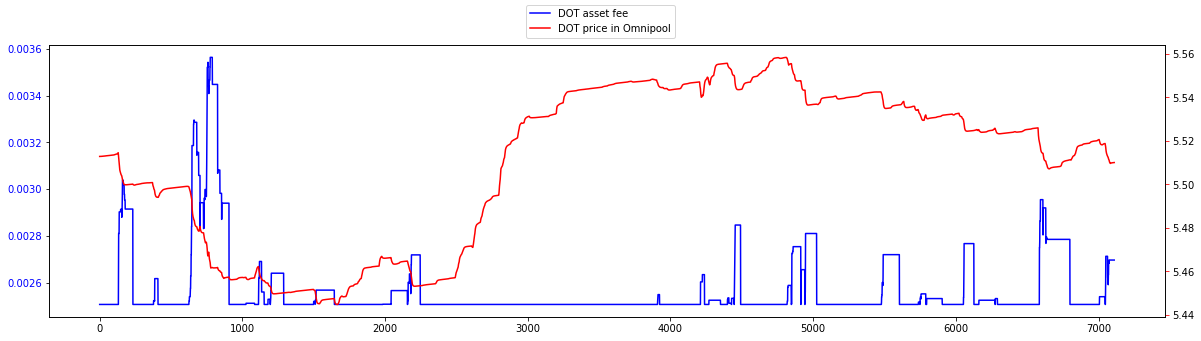

In [16]:
view_range = (0, len(blocks))
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.tick_params(axis='y', labelcolor="blue")
ax.plot(asset_fees[view_range[0]: view_range[1]], color='blue', label="DOT asset fee")
ax2 = ax.twinx()
ax2.plot(oraclize(dot_prices[view_range[0]: view_range[1]]), color='red', label="DOT price in Omnipool")
ax2.tick_params(axis='y', color="red")
fig.legend(loc="upper center")
plt.show()

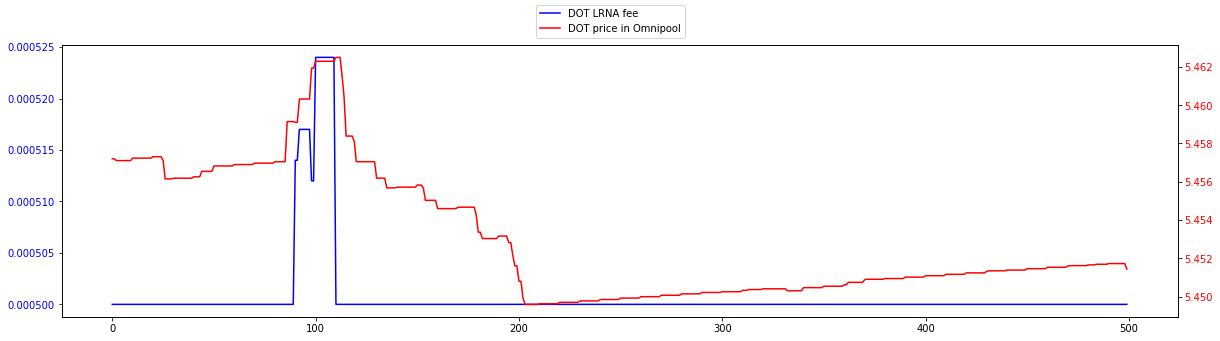

In [17]:
view_range = (1000, 1500)
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.tick_params(axis='y', labelcolor="blue")
ax.plot(lrna_fees[view_range[0]: view_range[1]], color='blue', label="DOT LRNA fee")
ax2 = ax.twinx()
ax2.plot(dot_prices[view_range[0]: view_range[1]], color='red', label="DOT price in Omnipool")
ax2.tick_params(axis='y', labelcolor="red")
fig.legend(loc='upper center')
plt.show()

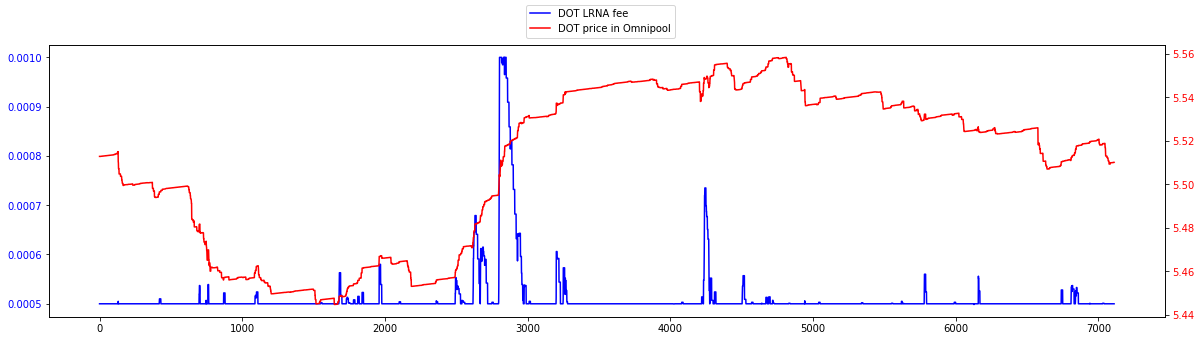

In [18]:
view_range = (0, len(blocks))
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.tick_params(axis='y', labelcolor="blue")
ax.plot(lrna_fees[view_range[0]: view_range[1]], color='blue', label="DOT LRNA fee")
ax2 = ax.twinx()
ax2.plot(dot_prices[view_range[0]: view_range[1]], color='red', label="DOT price in Omnipool")
ax2.tick_params(axis='y', labelcolor="red")
fig.legend(loc='upper center')
plt.show()

In [24]:
# get recorded market prices for the given time range
from model.processing import import_binance_prices
start_date=datetime.strptime(time_range[0], '%Y-%m-%dT%H:%M:%S.%fZ')
end_date=datetime.strptime(time_range[1], '%Y-%m-%dT%H:%M:%S.%fZ')
historical_price_data = import_binance_prices(
    assets=["DOT"],
    start_date=datetime.strftime(start_date, "%B %d %Y"),
    days=math.ceil((end_date - start_date).total_seconds() / (24 * 60 * 60))
)

In [45]:
# simulate with same trades and see if it comes out the same
from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, dynamicadd_asset_fee, dynamicadd_lrna_fee, usd_price
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices
from datetime import datetime
import math
import random

lrna_fee_amplification=1.0
lrna_fee_decay=0.000005
lrna_fee_min=0.0005
lrna_fee_max=0.001
asset_fee_amplification=1.0
asset_fee_decay=0.00001
asset_fee_min=0.0025
asset_fee_max=0.05


initial_omnipool_tvl = 10000000
dot_liquidity = 2319659
dot_lrna = dot_liquidity / dot_prices[0]
lrna_price_usd = dot_prices[0] * historical_price_data[0]['DOT']

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                'DOT': {'liquidity': dot_liquidity, 'LRNA': dot_lrna},
                'HDX': {'liquidity': 100000000, 'LRNA': 100000000 / 0.01 / lrna_price_usd},
                'USD': {'liquidity': 10000000, 'LRNA': 10000000 / lrna_price_usd}
            },
            lrna_fee=dynamicadd_lrna_fee(
                minimum=lrna_fee_min,
                amplification=lrna_fee_amplification,
                raise_oracle_name='fee_raise',
                decay=lrna_fee_decay,
                fee_max=lrna_fee_max,
            ),
            asset_fee=dynamicadd_asset_fee(
                minimum=asset_fee_min,
                amplification=asset_fee_amplification,
                raise_oracle_name='fee_raise',
                decay=asset_fee_decay,
                fee_max=asset_fee_max,
            ),
            oracles={'fee_raise': 10},
            preferred_stablecoin = 'USD',
        )
    },
    agents={
        'trader': Agent(
            holdings={tkn: 1000000000 for tkn in ['HDX', 'DOT', 'USD', 'LRNA']}
        )
    }
)

In [46]:
print('simulating')
events = []
simulate_state = initial_state.copy()
simulate_state.pools['omnipool'].lrna_fee_this_block = {'DOT': 0, 'HDX': 0, 'USD': 0}
simulate_state.pools['omnipool'].asset_fee_this_block = {'DOT': 0, 'HDX': 0, 'USD': 0}
trade_index = 0
for block in range(min_block, max_block):
    while trades_history[trade_index][0] == block:
        trade = trades_history[trade_index]
        amount = trade[1]
        lrna = trade[2]
        price = trade[3]
        trade_type = trade[6]
        simulate_state.pools['omnipool'].lrna_swap(
            agent = simulate_state.agents['trader'],
            delta_ra = amount if trade_type == 'sell' else -amount,
            tkn='DOT'
        )
        trade_index += 1
    simulate_state.pools['omnipool'].update()
    events.append(simulate_state.archive())
print('done')

simulating
done


In [47]:
len(list(filter(lambda x: x[6] == 'buy', trades_history)))

1316

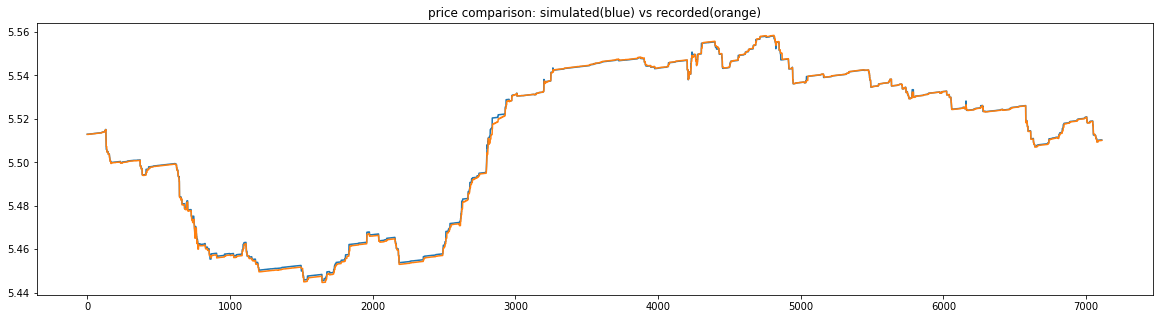

In [51]:
plt.figure(figsize=(20, 5))
plt.plot([event.pools['omnipool'].liquidity['DOT'] / event.pools['omnipool'].lrna['DOT'] for event in events])
plt.plot(dot_prices)
plt.title('price comparison: simulated(blue) vs recorded(orange)')
plt.show()

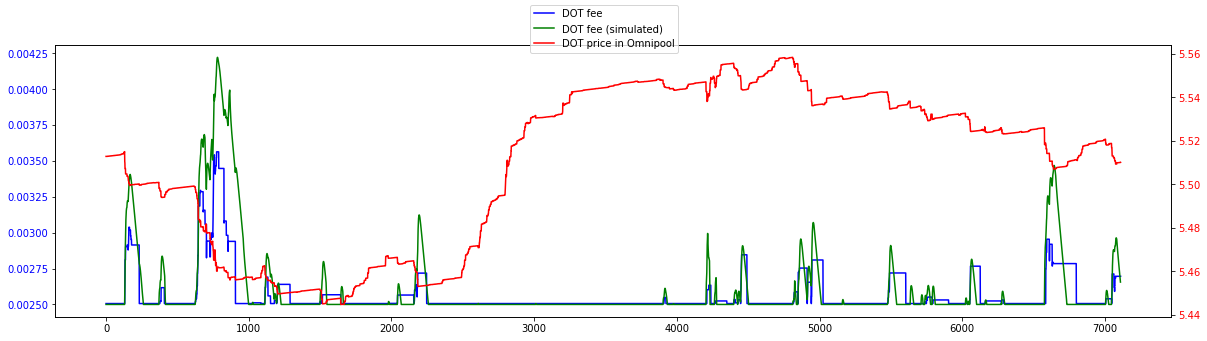

In [49]:
view_range = (0, len(blocks))
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.tick_params(axis='y', labelcolor="blue")
ax.plot(asset_fees[view_range[0]: view_range[1]], color='blue', label="DOT fee")
ax.plot([event.pools['omnipool'].last_fee['DOT'] for event in events], color='green', label = "DOT fee (simulated)")
ax2 = ax.twinx()
ax2.plot(dot_prices[view_range[0]: view_range[1]], color='red', label="DOT price in Omnipool")
ax2.tick_params(axis='y', labelcolor="red")
fig.legend(loc='upper center')
plt.show()

In [50]:
simulate_state.pools['omnipool'].asset_list

['DOT', 'HDX', 'USD']

In [ ]:
lrna_price_usd

In [ ]:
blocks[10], trades_history[1][0]

In [ ]:
len(events)

In [ ]:
len(trades_history)

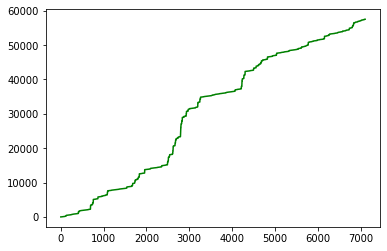

In [35]:
plt.plot([event.pools['omnipool'].current_block.volume_in['DOT'] for event in events[1:]], color='green', label = "DOT fee (simulated)")

In [ ]:
simulate_state